# Decision Trees - Example

Apply a Random Forest classifier, `RandomForest()` to the heart disease dataset

The data is hosted on UCI https://archive.ics.uci.edu/ml/datasets/Heart+Disease

we will need `load_heart_disease()` from last week's `Linear Example.ipynb`

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Load and prepare the data
**Question:** Can you update the function `load_heart_disease()` to download the file from the url if the file is not on disk?

In [2]:
def load_heart_disease():
    '''Load and pre-process heart disease data
    
    if processed.hungarian.data file is not present.
    
    it will be downloaded from
    https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data
    
    return: data(DataFrame)
    
    '''
    
    import os
    import requests
    
    
    file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data'
    file_name = file_url.split('/')[-1]
    
    if not os.path.isfile(file_name):
        print('Downloading from {}'.format(file_url))
        r = requests.get(file_url)
        with open(file_name,'wb') as output_file:
            output_file.write(r.content)
        
    data = pd.read_csv(file_name, 
                   na_values='?', 
                   names=[ 'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
                            'restecg', 'thalach', 'exang', 'oldpeak', 'slope',
                            'ca', 'thal', 'num'])
    
    # drop columns with many missing data
    data = data.drop(columns=['slope', 'ca', 'thal'])
    
    # fill in remaining missing data with mean() per column
    data = data.fillna(data.mean())
    
    return data

In [3]:
data = load_heart_disease()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294 entries, 0 to 293
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       294 non-null    int64  
 1   sex       294 non-null    int64  
 2   cp        294 non-null    int64  
 3   trestbps  294 non-null    float64
 4   chol      294 non-null    float64
 5   fbs       294 non-null    float64
 6   restecg   294 non-null    float64
 7   thalach   294 non-null    float64
 8   exang     294 non-null    float64
 9   oldpeak   294 non-null    float64
 10  num       294 non-null    int64  
dtypes: float64(7), int64(4)
memory usage: 25.4 KB


### Create feature matrix and target vector 

In [4]:
# Create feature matrix and target vector and print shapes
X = data.drop(columns='num')
y = data['num']
print(X.shape)
print(y.shape)

(294, 10)
(294,)


### Create training and test sets

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1,
                                                    stratify=y,
                                                    random_state=31)

print(X_train.shape)
print(X_test.shape)

(264, 10)
(30, 10)


In [6]:
y_train.value_counts()

num
0    169
1     95
Name: count, dtype: int64

In [7]:
y_test.value_counts()

num
0    19
1    11
Name: count, dtype: int64

## Apply `RandomForest()` and evaluate the performance 

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=58)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=58)

### Cross validation 

Are we over- or underfitting?

Using `cross_val_score()`

In [9]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X_train, y_train, cv=5)
scores 

array([0.83018868, 0.8490566 , 0.81132075, 0.79245283, 0.80769231])

In [10]:
#Calculate mean
scores.mean()

0.8181422351233673

Using `cross_validate()`

In [11]:
from sklearn.model_selection import cross_validate
scores = cross_validate(model, X_train, y_train, cv=5, 
                        scoring='accuracy',
                       return_train_score=True)
scores

{'fit_time': array([0.18168116, 0.16968083, 0.16465807, 0.16320372, 0.16219497]),
 'score_time': array([0.01447129, 0.01398873, 0.01450753, 0.01344538, 0.01396441]),
 'test_score': array([0.83018868, 0.8490566 , 0.81132075, 0.79245283, 0.80769231]),
 'train_score': array([1., 1., 1., 1., 1.])}

In [12]:
# Calculate means
for label_pair in [ ('train_score', 'train_score'), ('test_score', 'validation_score')]:
    print('{} = {:.3f}'.format(label_pair[1], scores[label_pair[0]].mean()))

train_score = 1.000
validation_score = 0.818


Likely overfitting and would need a less complex model to increase validation accuracy.

We could use: Pre-pruning by reducing maximum depth. More trees, or smaller max_features to reduce overfitting.

### Compare training and test accuracy


In [13]:
model.score(X_train, y_train)

1.0

In [14]:
model.score(X_test, y_test)

0.8

### The confusion matrix on the test set 

Your thoughts?

Text(113.9222222222222, 0.5, 'true value')

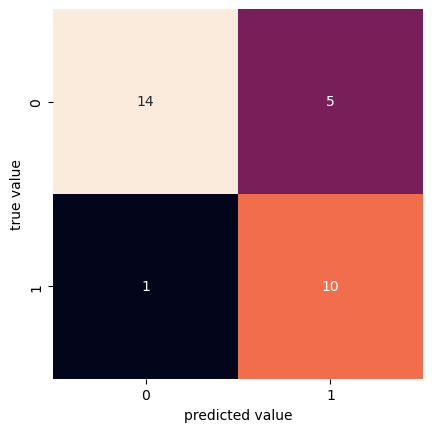

In [15]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(y_test, model.predict(X_test))

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value')

We make different mistakes than with `LogisticRegression()`. 

It might be time to go back to the feautures, or try a gradient boosted tree.

### Summarize the different scores 

In [16]:
scores = cross_validate(model, X_train, y_train, cv=5, 
                        scoring='accuracy',
                       return_train_score=True)

print('Training Accuracy (all data): {:.3f}'.format(model.score(X_train, y_train)))

print('Training Accuracy (cross-validation): {:.3f}'.format(scores['train_score'].mean()))

print('Validation Accuracy (cross-validation): {:.3f}'.format(scores['test_score'].mean()))

print('Test Accuracy (new data): {:.3f}'.format(model.score(X_test, y_test)))

Training Accuracy (all data): 1.000
Training Accuracy (cross-validation): 1.000
Validation Accuracy (cross-validation): 0.818
Test Accuracy (new data): 0.800
